In [290]:
import sys
sys.path.append("../")
import os
import glob
import time
import numpy as np
import nibabel as nb
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import SimpleITK as sitk
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from data.nifti_dataset import resample_nifti
from data.base_dataset import _roll2center_crop
from scipy.ndimage.measurements import center_of_mass
from skimage.measure import label, regionprops

from tensorflow.keras.optimizers import Adam
from options.test_options import TestOptions
from models import deep_strain_model
from utils import myocardial_strain
from scipy.ndimage import gaussian_filter
import DeepStrain.functions_collection as ff
import DeepStrain.Data_processing as Data_processing

In [291]:
main_path = '/mnt/mount_zc_NAS/Deepstrain'
data_path = '/mnt/mount_zc_NAS/HFpEF/data/HFpEF_data'

## Define Model 

To avoid using the command line scripts, here we create an `options` class to load the network directly. All we have to do is to specify the model path, etc. **For your part, download the ACDC dataset and change the path.**

In [4]:
# class Options():
    
#     def __init__(self):
        
#         self.datadir = os.path.join(main_path,'data/ACDC')
#         self.isTrain = False
#         self.volume_shape = (128,128,16,1) # in network the input shape is [None, 128, 128, 16,2]
#         self.pretrained_models_netS  = os.path.join(main_path,'models/trained/carson_Jan2021.h5')
#         self.pretrained_models_netME = os.path.join(main_path,'models/trained/carmen_Jan2021.h5')
#         # self.pretrained_models_netME = os.path.join(main_path,'models/fine_tune_carmen/ID_0015/models/model-005.hdf5')
        
# opt = Options()

# model = deep_strain_model.DeepStrain(Adam, opt=opt)
# netME = model.get_netME()

in networks, V shape:  (None, 128, 128, 16, 2)
in network, we use 3D


2023-11-03 02:13:29.283703: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-11-03 02:13:29.284469: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-11-03 02:13:29.295961: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-03 02:13:29.296783: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:13:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.44GiB deviceMemoryBandwidth: 1.41TiB/s
2023-11-03 02:13:29.296813: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-11-03 02:13:29.298558: I tensorflow/stream_executor/platform/defau

## Global End-Systolic Strain

the segmentation is done manually

1 8
original shape:  (256, 256, 14) (256, 256, 14) (256, 256, 14)
original pixel dim is:  (1.171875, 1.171875, 10.246957)
labels:  [0. 1. 2. 3.]
after concat, shape: , (256, 256, 14, 2)
after resample, shape:  (240, 240, 16, 2) (240, 240, 16, 2)
after crop, shape:  (128, 128, 16, 2) (128, 128, 16, 2)  Labels:  [0. 1. 2. 3.]
before input into the model, the shape:  (1, 128, 128, 16) (1, 128, 128, 16)
y_t shape:  (1, 128, 128, 16, 3)


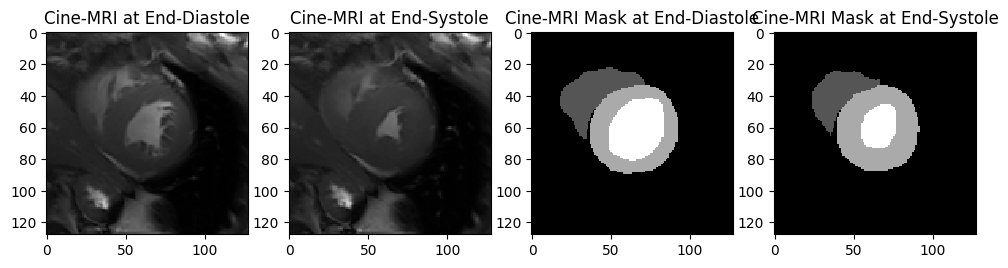

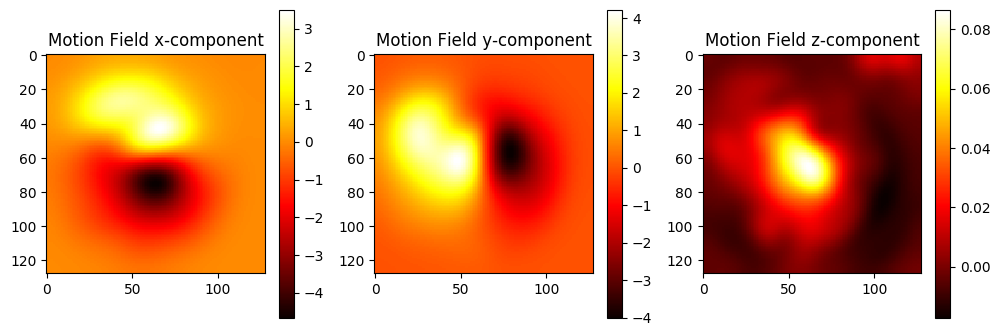

Radial strain:  8.60354902486556
Circumferential strain:  -12.703494234200946
strain image:  (128, 128, 16)


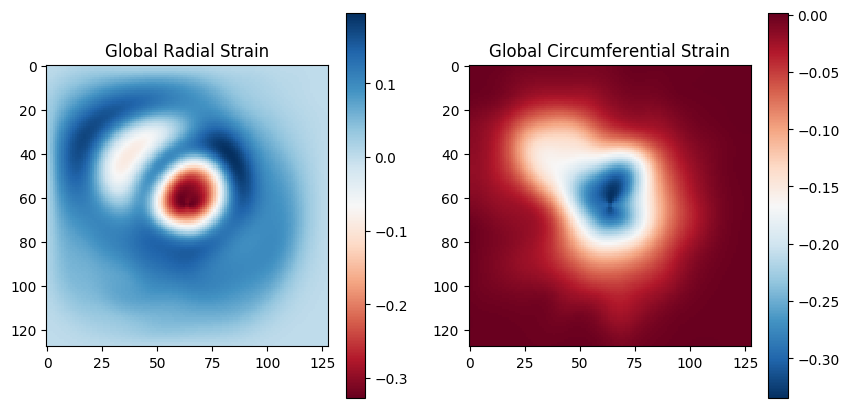

In [294]:
patient_id = 'ID_0015'
# first: get the ED and ES frame
spreadsheet = pd.read_excel(os.path.join(data_path, 'Patient_list', 'Important_HFpEF_Patient_list_unique_patient_w_notes.xlsx' ))
patient_id_num = ff.ID_00XX_to_XX(patient_id)
patient_row = spreadsheet.loc[spreadsheet['OurID'] == patient_id_num]
ED = patient_row['ED'].values[0].astype(int)
ES = patient_row['ES'].values[0].astype(int)
print(ED,ES)

# second: load img and seg
patient_img_folder = os.path.join(data_path, 'nii_img', patient_id)
patient_seg_folder = os.path.join(data_path, 'nii_manual_seg', patient_id)

V_nifti_ED = nb.load(os.path.join(patient_img_folder, 'Org3D_frame' + str(ED) + '.nii.gz'))
V_nifti_ES = nb.load(os.path.join(patient_img_folder, 'Org3D_frame' + str(ES) + '.nii.gz'))

M_nifti_ED = nb.load(os.path.join(patient_seg_folder, 'SAX_ED_seg.nii.gz'))
M_nifti_ES = nb.load(os.path.join(patient_seg_folder, 'SAX_ES_seg.nii.gz'))

M_nifti_ED_RV = nb.load(os.path.join(main_path,'results/trained/seg/' ,patient_id,'pred_seg_frame' + str(ED) + '.nii.gz'))
M_nifti_ES_RV = nb.load(os.path.join(main_path,'results/trained/seg/' ,patient_id,'pred_seg_frame' + str(ES) + '.nii.gz'))

# third: preprocess - change the label in segmentation: RV = 1, Myocardium = 2, LV = 3
M_ED = np.round(M_nifti_ED.get_fdata()).astype(int)
M_ED_RV = np.round(M_nifti_ED_RV.get_fdata()).astype(int)
M_ED[M_ED==1] = 3
M_ED[M_ED_RV==3] = 1
M_nifti_ED = nb.Nifti1Image(M_ED, affine=M_nifti_ED.affine, header=M_nifti_ED.header)

M_ES = np.round(M_nifti_ES.get_fdata()).astype(int)
M_ES_RV = np.round(M_nifti_ES_RV.get_fdata()).astype(int)
M_ES[M_ES==1] = 3
M_ES[M_ES_RV==3] = 1
M_nifti_ES = nb.Nifti1Image(M_ES, affine=M_nifti_ES.affine, header=M_nifti_ES.header)

print('original shape: ',V_nifti_ED.get_fdata().shape, M_nifti_ED.get_fdata().shape, M_nifti_ES.get_fdata().shape)
print('original pixel dim is: ', V_nifti_ED.header.get_zooms())
print('labels: ', np.unique(M_nifti_ED.get_fdata()))


# fourth: prepare input
V_nifti = nb.funcs.concat_images((V_nifti_ED, V_nifti_ES))
M_nifti = nb.funcs.concat_images((M_nifti_ED, M_nifti_ES))
print('after concat, shape: ,', V_nifti.shape)

# data was trained with:
#  in-plane resolution of 1.25 mm x 1.25 mm
#  number of slices = 16
#  variable slice thickness since we specify number of slices
V_nifti = resample_nifti(V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=16)
M_nifti = resample_nifti(M_nifti, order=0, in_plane_resolution_mm=1.25, number_of_slices=16)
print('after resample, shape: ', V_nifti.shape, M_nifti.shape)

# calculate center of mass using the first frame as reference. This is needed for cropping to 128x128
center = center_of_mass(M_nifti.get_fdata()[:,:,:,0]==2) # RV = 1, Myocardium = 2, LV = 3
V = _roll2center_crop(x=V_nifti.get_fdata(), center=center)
M = _roll2center_crop(x=M_nifti.get_fdata(), center=center)
print('after crop, shape: ', V.shape, M.shape, ' Labels: ', np.unique(M))

plt.figure(figsize=(12,3))
plt.subplot(141); plt.imshow(V[:,:,7,0], cmap='gray'); plt.title('Cine-MRI at End-Diastole')
plt.subplot(142); plt.imshow(V[:,:,7,1], cmap='gray'); plt.title('Cine-MRI at End-Systole')
plt.subplot(143); plt.imshow(M[:,:,7,0], cmap='gray'); plt.title('Cine-MRI Mask at End-Diastole')
plt.subplot(144); plt.imshow(M[:,:,7,1], cmap='gray'); plt.title('Cine-MRI Mask at End-Systole')

# 
V = ff.normalize_image(V)
nx, ny, nz, nt = V.shape
V_0 =  np.repeat(V[:,:,:,:1], nt-1, axis=-1)
V_t =  V[:,:,:,1:]

V_0 = np.transpose(V_0, (3,0,1,2))
V_t = np.transpose(V_t, (3,0,1,2))
print('before input into the model, the shape: ', V_0.shape, V_t.shape)

# fifth: predict motion vector
# y_t = netME([V_0, V_t]).numpy()
y_t = nb.load(os.path.join(main_path, 'models/fine_tune_carmen/ID_0015/mvf.nii.gz')).get_fdata()
y_t = y_t[None,...]
print('y_t shape: ', y_t.shape)

# smooth the motion fields. Note that these motion fields can be used to warp points individually, or could be 
# used to deform an endocardial contour. 
y_t = gaussian_filter(y_t, sigma=(0,2,2,0,0))

plt.figure(figsize=(12,4))
plt.subplot(131); plt.imshow(y_t[0,:,:,7,0], cmap='hot'); plt.title('Motion Field x-component'); plt.colorbar()
plt.subplot(132); plt.imshow(y_t[0,:,:,7,1], cmap='hot'); plt.title('Motion Field y-component'); plt.colorbar()
plt.subplot(133); plt.imshow(y_t[0,:,:,7,2], cmap='hot'); plt.title('Motion Field z-component'); plt.colorbar()
plt.show()

# last: calculate strain 
mask_end_diastole = M[..., 0]
mask_end_systole = M[..., 1]
    
strain = myocardial_strain.MyocardialStrain(mask=mask_end_diastole, flow=y_t[0,:,:,:,:])
strain.calculate_strain(lv_label=2)

print('Radial strain: ', 100*strain.Err[strain.mask_rot==2].mean())  # mask_rot means moves the whole mask (segmentation) to the center of myocardium
print('Circumferential strain: ', 100*strain.Ecc[strain.mask_rot==2].mean())
print('strain image: ', strain.Err.shape)

plt.figure(figsize=(10,5))
plt.subplot(121); plt.imshow(strain.Err[:,:,7], cmap='RdBu'); plt.title('Global Radial Strain'); plt.colorbar()
plt.subplot(122); plt.imshow(strain.Ecc[:,:,7], cmap='RdBu_r'); plt.title('Global Circumferential Strain'); plt.colorbar()
plt.show() 

# save the motion field:
a = nb.Nifti1Image(y_t[0,:,:,:,:] , affine=V_nifti_ED.affine, header=V_nifti_ED.header)
nb.save(a, os.path.join(main_path, 'models/fine_tune_carmen/ID_0015/mvf.nii.gz'))


# Segmemtation

In [3]:
class Options():
    
    def __init__(self):
        
        self.datadir = os.path.join(main_path,'data/ACDC')
        self.isTrain = False
        self.image_shape = (128,128,1) # 2D
        self.nlabels = 4
        self.pretrained_models_netS  = os.path.join(main_path,'models/trained/carson_Jan2021.h5')
        self.pretrained_models_netME = os.path.join(main_path,'models/trained/carmen_Jan2021.h5')
        
opt = Options()

model = deep_strain_model.DeepStrain(Adam, opt=opt)
netS  = model.get_netS()

from data import base_dataset
def get_mask(V):  # by trained netS
    nx, ny, nz, nt = V.shape
    
    M = np.zeros((nx,ny,nz,nt))
    v = V.transpose((2,3,0,1)).reshape((-1,nx,ny)) # (nz*nt,nx,ny)
    v = ff.normalize_image(v)
    m = netS(v[:,nx//2-64:nx//2+64,ny//2-64:ny//2+64,None])
    M[nx//2-64:nx//2+64,ny//2-64:ny//2+64] += np.argmax(m, -1).transpose((1,2,0)).reshape((128,128,nz,nt))
    
    return M

in network, we use 2D


2023-10-25 15:08:44.680712: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-10-25 15:08:44.681545: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-10-25 15:08:44.796812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-25 15:08:44.798535: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:13:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.44GiB deviceMemoryBandwidth: 1.41TiB/s
2023-10-25 15:08:44.798571: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-10-25 15:08:44.800727: I tensorflow/stream_executor/platform/defau

In [4]:
patient_list = ff.find_all_target_files(['ID_*'],os.path.join(data_path, 'nii_manual_seg' ))

In [12]:
for k in range(0,patient_list.shape[0]):
    patient_id = os.path.basename(patient_list[k])
    # first: get the ED and ES frame
    spreadsheet = pd.read_excel(os.path.join(data_path, 'Patient_list', 'Important_HFpEF_Patient_list_unique_patient_w_notes.xlsx' ))
    # spreadsheet = pd.read_excel(os.path.join(data_path, 'Patient_list', 'full_list.xlsx' ))
    patient_id_num = ff.ID_00XX_to_XX(patient_id)
    patient_row = spreadsheet.loc[spreadsheet['OurID'] == patient_id_num]
    ED = patient_row['ED'].values[0].astype(int)
    ES = patient_row['ES'].values[0].astype(int)
    print(patient_id, ED,ES)

    # second: load img 
    patient_img_folder = os.path.join(data_path, 'nii_img', patient_id)

    V_nifti_ED = nb.load(os.path.join(patient_img_folder, 'Org3D_frame' + str(ED) + '.nii.gz'))
    V_nifti_ES = nb.load(os.path.join(patient_img_folder, 'Org3D_frame' + str(ES) + '.nii.gz'))###########
    V_nifti = nb.funcs.concat_images((V_nifti_ED, V_nifti_ES))
    
    original_shape = V_nifti.shape
    print('original shape: ',original_shape)

    # third: resample img
    V_nifti_resampled = resample_nifti(V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=None)
    # here we normalize per image, not volume
    V = V_nifti_resampled.get_fdata()
    V = ff.normalize_image(V, axis=(0,1))
    # print('after resample: ', V.shape)

    # fourth: get rough mask (not cropped and centered)
    M = get_mask(V)


    # fifth: crop and center
    center_resampled = center_of_mass(M[:,:,:,0]==2)
    V = base_dataset.roll_and_pad_256x256_to_center(x=V, center=center_resampled)
    M = base_dataset.roll_and_pad_256x256_to_center(x=M, center=center_resampled)
    center_resampled_256x256 = center_of_mass(M==3)
    # print('crop to 256x256, shape: ', V.shape, M.shape)
    # we save all this info to invert the segmentation bask to its original location/resolution
    nifti_info = {'affine'           : V_nifti.affine,
                'affine_resampled' : V_nifti_resampled.affine,
                'zooms'            : V_nifti.header.get_zooms(),
                'zooms_resampled'  : V_nifti_resampled.header.get_zooms(),
                'shape'            : V_nifti.shape,
                'shape_resampled'  : V_nifti_resampled.shape,
                'center_resampled' : center_resampled,
                'center_resampled_256x256' : center_resampled_256x256} 

    # sixth: get mask again
    M = get_mask(V)[128-64:128+64,128-64:128+64]
    # print('in second segmentation output, shape: ', M.shape)
    # change label: label 3 becomes label 1, label 1 becomes label 3
    M_relabel = np.zeros(M.shape)
    M_relabel[M==3] = 1.
    M_relabel[M==1] = 3.
    M_relabel[M==2] = 2.
    M = np.copy(M_relabel)

    M_nifti = base_dataset.convert_back_to_nifti(M, nifti_info, inv_256x256=True, order=0, mode='nearest')
    print('final segmentation output, shape: ', M_nifti.shape)
    final_shape = M_nifti.shape
    
    if original_shape[0] != final_shape[0] or original_shape[1] != final_shape[1]:
        M_data = M_nifti.get_fdata()
        new_M_data = np.zeros([original_shape[0], original_shape[1], final_shape[2], final_shape[3]])
        for z in range(M_data.shape[3]):
            new_M_data[:,:,:,z] = Data_processing.crop_or_pad(M_data[:,:,:,z], [original_shape[0], original_shape[1], final_shape[2]],value = 0)
        M_nifti = nb.Nifti1Image(new_M_data, affine=M_nifti.affine)
        print('after correction: final segmentation output, shape: ', M_nifti.shape)


    # save
    save_folder = os.path.join(main_path, 'results/trained/seg', patient_id); ff.make_folder([save_folder])
    a = np.round(M_nifti.get_fdata()[:,:,:,0])
    # remove the scatters
    a = ff.remove_scatter(a, 2)
    a = ff.remove_scatter(a, 1)
    a = ff.remove_scatter(a, 3)
    a = nb.Nifti1Image(a, affine=M_nifti.affine)
    nb.save(a, os.path.join(save_folder, 'pred_seg_frame' + str(ED) + '.nii.gz'))
    a = np.round(M_nifti.get_fdata()[:,:,:,1])
    # remove the scatters
    a = ff.remove_scatter(a, 2)
    a = ff.remove_scatter(a, 1)
    a = ff.remove_scatter(a, 3)
    a = nb.Nifti1Image(a, affine=M_nifti.affine)
    nb.save(a, os.path.join(save_folder, 'pred_seg_frame' + str(ES) + '.nii.gz'))





ID_0011 1 14
original shape:  (312, 384, 30, 2)
final segmentation output, shape:  (312, 384, 30, 2)
ID_0109 1 9
original shape:  (192, 192, 15, 2)
final segmentation output, shape:  (192, 192, 15, 2)
ID_0128 1 10
original shape:  (216, 256, 15, 2)
final segmentation output, shape:  (216, 256, 15, 2)
ID_0131 1 10
original shape:  (256, 256, 14, 2)
final segmentation output, shape:  (256, 256, 14, 2)
ID_0151 1 11
original shape:  (256, 256, 20, 2)
final segmentation output, shape:  (256, 256, 20, 2)
ID_0175 5 19
original shape:  (162, 192, 15, 2)
final segmentation output, shape:  (162, 192, 15, 2)
ID_0198 1 10
original shape:  (162, 192, 14, 2)
final segmentation output, shape:  (162, 192, 14, 2)
ID_0212 1 8
original shape:  (216, 256, 13, 2)
final segmentation output, shape:  (216, 256, 13, 2)
ID_0227 1 9
original shape:  (232, 256, 14, 2)
final segmentation output, shape:  (232, 256, 14, 2)
ID_0252 1 10
original shape:  (256, 256, 17, 2)
final segmentation output, shape:  (256, 256, 

In [5]:
# check the quality
dice_ed_lv_list = []
dice_ed_myo_list = []
dice_es_lv_list = []
dice_es_myo_list = []
for k in range(0,patient_list.shape[0]):
    patient_id = os.path.basename(patient_list[k])
    # first: get the ED and ES frame
    spreadsheet = pd.read_excel(os.path.join(data_path, 'Patient_list', 'Important_HFpEF_Patient_list_unique_patient_w_notes.xlsx' ))
    patient_id_num = ff.ID_00XX_to_XX(patient_id)
    patient_row = spreadsheet.loc[spreadsheet['OurID'] == patient_id_num]
    ED = patient_row['ED'].values[0].astype(int)
    ES = patient_row['ES'].values[0].astype(int)
    print(patient_id, ED,ES)

    # second: load gt segmentation
    patient_seg_folder = os.path.join(data_path, 'nii_manual_seg', patient_id)
    M_ED_gt = np.round(nb.load(os.path.join(patient_seg_folder, 'SAX_ED_seg.nii.gz')).get_fdata()).astype(int)
    M_ES_gt = np.round(nb.load(os.path.join(patient_seg_folder, 'SAX_ES_seg.nii.gz')).get_fdata()).astype(int)

    # third: load pred segmentation
    patient_seg_folder = os.path.join(main_path, 'results/seg', patient_id)
    M_ED_pred = np.round(nb.load(os.path.join(patient_seg_folder, 'pred_seg_frame' + str(ED) + '.nii.gz')).get_fdata()).astype(int)
    M_ES_pred = np.round(nb.load(os.path.join(patient_seg_folder, 'pred_seg_frame' + str(ES) + '.nii.gz')).get_fdata()).astype(int)

    # fourth: calculate dice
    dice_ED_lv = ff.np_categorical_dice(M_ED_pred, M_ED_gt, 1)
    dice_ED_myo = ff.np_categorical_dice(M_ED_pred, M_ED_gt, 2)
    dice_ES_lv = ff.np_categorical_dice(M_ES_pred, M_ES_gt, 1)
    dice_ES_myo = ff.np_categorical_dice(M_ES_pred, M_ES_gt, 2)
    print('ED dice: ', dice_ED_lv, dice_ED_myo)
    print('ES dice: ', dice_ES_lv, dice_ES_myo)

    dice_ed_lv_list.append(dice_ED_lv)
    dice_ed_myo_list.append(dice_ED_myo)
    dice_es_lv_list.append(dice_ES_lv)
    dice_es_myo_list.append(dice_ES_myo)

dice_ed_lv_list = np.asarray(dice_ed_lv_list)
dice_ed_myo_list = np.asarray(dice_ed_myo_list)
dice_es_lv_list = np.asarray(dice_es_lv_list)
dice_es_myo_list = np.asarray(dice_es_myo_list)
print('ED dice: ', np.mean(dice_ed_lv_list),np.std(dice_ed_lv_list), np.mean(dice_ed_myo_list), np.std(dice_ed_myo_list))
print('ES dice: ', np.mean(dice_es_lv_list),np.std(dice_es_lv_list), np.mean(dice_es_myo_list), np.std(dice_es_myo_list))


NameError: name 'patient_list' is not defined

subject 1 / 100
original shape:  (216, 256, 10, 30)
after resample:  (270, 320, 10, 30)
0 5
in segmentation unique:  [0. 1. 2. 3.]
5 10
in segmentation unique:  [0. 1. 2. 3.]
10 15
in segmentation unique:  [0. 1. 2. 3.]
15 20
in segmentation unique:  [0. 1. 2. 3.]
20 25
in segmentation unique:  [0. 1. 2. 3.]
25 30
in segmentation unique:  [0. 1. 2. 3.]
in first segmentation output, shape:  (270, 320, 10, 30)
crop to 256x256, shape:  (256, 256, 10, 30) (256, 256, 10, 30)
in segmentation unique:  [0. 1. 2. 3.]
in second segmentation output, shape:  (128, 128, 10, 30)
final segmentation output, shape:  (216, 256, 10, 30)  labels:  [0.     0.0625 0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5    0.5625
 0.625  0.6875 0.75   0.8125 0.875  0.9375 1.     1.0625 1.125  1.1875
 1.25   1.3125 1.375  1.4375 1.5    1.5625 1.625  1.6875 1.75   1.8125
 1.875  1.9375 2.     2.0625 2.125  2.1875 2.25   2.375  2.4375 2.5
 2.5625 2.625  2.75   2.8125 2.875  2.9375 3.    ]


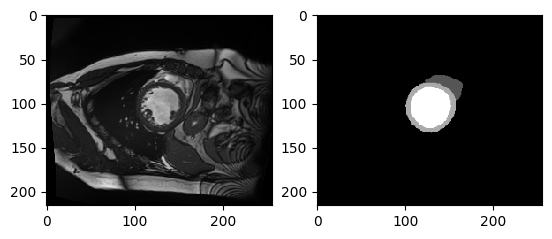

total time: 9.93598484992981


In [46]:
start = time.time()
for j, id in enumerate(range(1, 2)):
    print('subject %d / %d'%(j+1, 100))
    patientid = 'patient%.3d'%(id)
    patient_folder = os.path.join(os.path.join(opt.datadir, 'training', patientid))
    info = pd.read_csv(os.path.join(patient_folder, 'info.cfg'), sep=':', header=None, index_col=False).T
    info.columns = info.iloc[0]
    info = info[1:]
    
    # notice that in this case the number of slices is set to none, therefore the resolution is kept
    # along the slice dimension.
    V_nifti = nb.load(os.path.join(patient_folder, patientid+'_4d.nii.gz'))
    print('original shape: ',V_nifti.get_fdata().shape)
    V_nifti_resampled = resample_nifti(V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=None)
    
    # here we normalize per image, not volume
    V = V_nifti_resampled.get_fdata()
    V = ff.normalize_image(V, axis=(0,1))
    print('after resample: ', V.shape)
    
    # In this case we don't yet have a segmentation we can use to crop the image. 
    # In most cases we can simply center crop (see `get_mask` function): 
    # M = get_mask(V)
    
    # However, in some instances the image could end up outside the FOV. While this is unlikely, please inspect 
    # your data.
    
    if False:
        # ONLY IF YOU KNOW YOUR IMAGE IS ROUGHLY NEAR CENTER 
        M_nifti_resampled = nib.Nifti1Image(M, affine=V_nifti_resampled.affine)
        # resample back to original resolution
        M_nifti = base_dataset.resample_nifti_inv(nifti_original=M_nifti_resampled, 
                                                  zooms=M_nifti_resampled.header.get_zooms()[:3], 
                                                  order=0, mode='nearest')
        
    else:
        # We could use VCN to center the heart, but an alternative approach is to use V as an approximate segmentation
        # to center the image. This of course means that we need to do the inverse opereation if we want to recover 
        # the image as a nifti. 

        # get approximate segmentation (in most cases this is enough)
        # get a time frame every 5 frames
        M = np.zeros(V.shape)
        for tf in range(0, V.shape[-1]//5 + 1):
            start_tf = tf*5
            if start_tf == V.shape[-1]:
                break
            end_tf = start_tf+5
            if end_tf > V.shape[-1]:
                end_tf = V.shape[-1]
            else:
                end_tf = start_tf+5
            print(start_tf, end_tf)
            V_partial = V[:,:,:, start_tf:end_tf]
            M_partial = get_mask(V_partial) 
            M[:,:,:, start_tf:end_tf] = M_partial           
        # M = get_mask(V)
        print('in first segmentation output, shape: ' , M.shape)

        # now we calculate center of mass using the first frame as reference as before.
        center_resampled = center_of_mass(M[:,:,:,0]==2)
        V = base_dataset.roll_and_pad_256x256_to_center(x=V, center=center_resampled)
        M = base_dataset.roll_and_pad_256x256_to_center(x=M, center=center_resampled)
        center_resampled_256x256 = center_of_mass(M==3)
        print('crop to 256x256, shape: ', V.shape, M.shape)

        # we save all this info to invert the segmentation bask to its original location/resolution
        nifti_info = {'affine'           : V_nifti.affine,
                      'affine_resampled' : V_nifti_resampled.affine,
                      'zooms'            : V_nifti.header.get_zooms(),
                      'zooms_resampled'  : V_nifti_resampled.header.get_zooms(),
                      'shape'            : V_nifti.shape,
                      'shape_resampled'  : V_nifti_resampled.shape,
                      'center_resampled' : center_resampled,
                      'center_resampled_256x256' : center_resampled_256x256} 

        M = get_mask(V)[128-64:128+64,128-64:128+64]
        print('in second segmentation output, shape: ', M.shape)
        M_nifti = base_dataset.convert_back_to_nifti(M, nifti_info, inv_256x256=True, order=0, mode='nearest')
        print('final segmentation output, shape: ', M_nifti.shape, ' labels: ', np.unique(M_nifti.get_fdata()))

        if j == 0:
            plt.subplot(121); plt.imshow(V_nifti.get_fdata()[:,:,5,0], cmap='gray')
            plt.subplot(122); plt.imshow(M_nifti.get_fdata()[:,:,5,0], cmap='gray')
            plt.show()

        # easy. Let's save the results now. 
        M_nifti.to_filename(os.path.join(patient_folder, patientid+'_4d_pred.nii.gz'))

end = time.time()
print('total time:', end - start)    

Let's plot an example. Change `id` to change subjects: 

In [44]:
id = 1
# save the result
patientid = 'patient%.3d'%(id)
patient_folder = os.path.join(os.path.join(opt.datadir, 'training', patientid))
save_folder = os.path.join(patient_folder, '4d_per_frame')
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

V_nifti = nb.load(os.path.join(patient_folder, patientid+'_4d.nii.gz'))
# save each volumn along the last dimension
for i in range(0,V_nifti.get_fdata().shape[-1]):
    a = V_nifti.get_fdata()[:,:,:,i]
    a = nb.Nifti1Image(np.flip(a,axis = 1), affine=V_nifti.affine)
    nb.save(a, os.path.join(save_folder, patientid+'_frame%.2d.nii.gz'%(i)))

    
M_nifti = nb.load(os.path.join(patient_folder, patientid+'_4d_pred.nii.gz'))
# save each volumn along the last dimension
for i in range(0,M_nifti.get_fdata().shape[-1]):
    a = M_nifti.get_fdata()[:,:,:,i]
    a = nb.Nifti1Image(np.flip(a,axis = 1), affine=M_nifti.affine)
    nb.save(a, os.path.join(save_folder, patientid+'_frame%.2d_pred.nii.gz'%(i)))

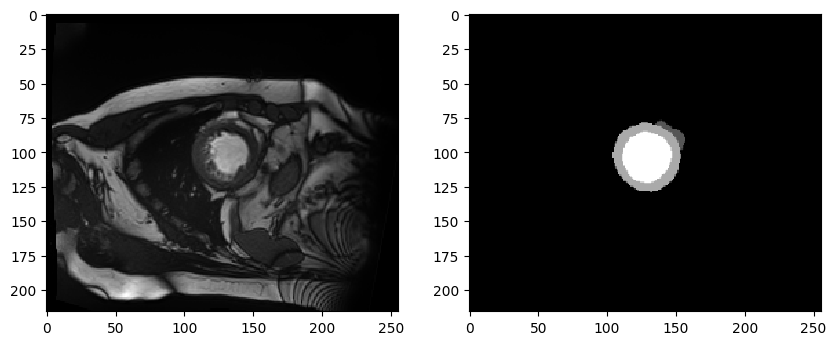

In [39]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(V_nifti.get_fdata()[:,:,7,6], cmap='gray')
plt.subplot(122)
plt.imshow(M_nifti.get_fdata()[:,:,7,6], cmap='gray')

Text(0, 0.5, 'Volume (mL)')

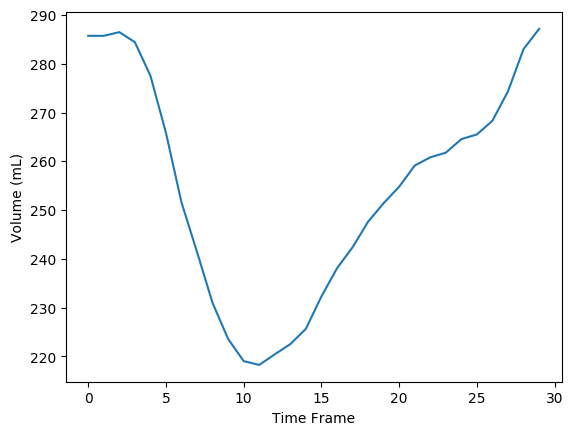

In [45]:
plt.plot((M_nifti.get_fdata()==3).sum(axis=(0,1,2))*np.prod(M_nifti.header.get_zooms()[:3])/1000)
plt.xlabel('Time Frame')
plt.ylabel('Volume (mL)')

#### Motion Estimation

Now that we have the 4D segmentations we can calculate strain: 

In [57]:
df = {'SubjectID':[], 'RadialStain':[], 'CircumferentialStrain':[], 'TimeFrame':[], 'Group':[]}

start = time.time()
for j, id in enumerate(range(1, 2)):
    print('subject %d / %d'%(j+1, 100))
    patientid = 'patient%.3d'%(id)
    patient_folder = os.path.join(os.path.join(opt.datadir, 'training', patientid))
    info = pd.read_csv(os.path.join(patient_folder, 'info.cfg'), sep=':', header=None, index_col=False).T
    info.columns = info.iloc[0]
    info = info[1:]
    
    group = info.Group.item().strip(' ')
    
    V_nifti = nib.load(os.path.join(patient_folder, patientid+'_4d.nii.gz'))
    M_nifti = nib.load(os.path.join(patient_folder, patientid+'_4d_pred.nii.gz'))
    print('shape: ', V_nifti.shape, M_nifti.shape)

    V_nifti_resampled = resample_nifti(V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=16)
    M_nifti_resampled = resample_nifti(M_nifti, order=0, in_plane_resolution_mm=1.25, number_of_slices=16)


    center = center_of_mass(M_nifti_resampled.get_fdata()[:,:,:,0]==2)
    V = _roll2center_crop(x=V_nifti_resampled.get_fdata(), center=center)
    M = _roll2center_crop(x=M_nifti_resampled.get_fdata(), center=center)
    print('after resample and crop: ', V.shape, M.shape)
    
    V = normalize(V, axis=(0,1,2))
    
    V = V.transpose((3,0,1,2))
    M = M.transpose((3,0,1,2))
    
    V_0 = np.repeat(V[:1], len(V)-1, axis=0)[...,None]
    V_t = V[1:][...,None]
    print('before input, the shape: ', V_0.shape, V_t.shape)
    
    y_t = netME([V_0, V_t]).numpy()
    y_t = gaussian_filter(y_t, sigma=(0,2,2,0,0))
    print('motion shape: ', y_t.shape)

    mask_end_diastole = M[0]

    for time_frame in range(len(y_t)):

        strain = myocardial_strain.MyocardialStrain(mask=mask_end_diastole, flow=y_t[time_frame,:,:,:,:])
        strain.calculate_strain(lv_label=2)

        df['SubjectID']             += [id]
        df['RadialStain']           += [100*strain.Err[strain.mask_rot==2].mean()]   
        df['CircumferentialStrain'] += [100*strain.Ecc[strain.mask_rot==2].mean()]
        df['TimeFrame']             += [time_frame]
        df['Group']                 += [group]
    
    
df = pd.DataFrame(df)
print(df)

subject 1 / 100
shape:  (216, 256, 10, 30) (216, 256, 10, 30)


after resample and crop:  (128, 128, 16, 30) (128, 128, 16, 30)
before input, the shape:  (29, 128, 128, 16, 1) (29, 128, 128, 16, 1)
motion shape:  (29, 128, 128, 16, 3)
    SubjectID  RadialStain  CircumferentialStrain  TimeFrame Group
0           1    -0.162543              -0.068752          0   DCM
1           1    -1.269727              -1.024866          1   DCM
2           1    -1.606462              -2.140671          2   DCM
3           1    -0.612247              -2.977338          3   DCM
4           1     1.158512              -3.978353          4   DCM
5           1     3.029975              -4.909955          5   DCM
6           1     4.756115              -5.709644          6   DCM
7           1     6.342717              -6.377964          7   DCM
8           1     7.619605              -6.888348          8   DCM
9           1     8.582341              -7.153746          9   DCM
10          1     9.154124              -7.201612         10   DCM
11          1     9.13617

#### Comparison 

The figure below shows our published figure. 

In [90]:
from IPython.display import Image
Image(url= "https://www.frontiersin.org/files/Articles/730316/fcvm-08-730316-HTML-r1/image_m/fcvm-08-730316-g007.jpg")

And these are the results based on this repo: 

<AxesSubplot:xlabel='TimeFrame', ylabel='RadialStain'>

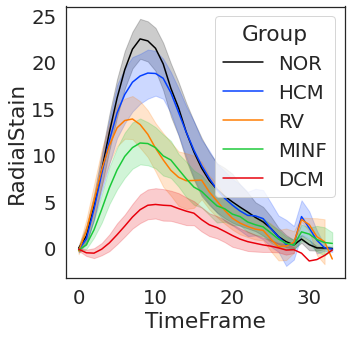

In [104]:
groups = ['NOR','HCM','RV','MINF','DCM']

current_palette = sns.color_palette()
current_palette = [(0,0,0)] + current_palette
sns.set(style='white', font_scale=1.8, palette="bright")

plt.figure(figsize=(5,5))
sns.lineplot(x='TimeFrame', y='RadialStain', hue='Group', data=df, palette=current_palette[:5], hue_order=groups)

### WHY THE DIFFERENCES? 

The images are not identical. In this notebook we are not taking into account the temporal resolution of the datasets. This can be extracted from the DICOMs. In fact, the temporal resolution is required to evaluate strain rate. We will address this in later notebooks. 